# Weather Compensation Control

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('simulation_results_finished.csv')
outdoor_temp_series = df['Dry-bulb temperature (°C)']

In [3]:
def calculate_desired_flow_temp(lower_temp, upper_temp, lower_flow, upper_flow, outdoor_temp):
    """Heating Curve Calculation

    Args:
        lower_temp (float): lower outdoor temperature
        upper_temp (float): upper outdoor temperature
        lower_flow (float): lower flow temperature
        upper_flow (float): upper flow temperature
        outdoor_temp (float): outdoor temperature
    """
    if outdoor_temp < lower_temp:
        return upper_flow
    elif outdoor_temp > upper_temp:
        return lower_flow
    else:
        return lower_flow + ((upper_flow - lower_flow) / (upper_temp - lower_temp)) * (upper_temp - outdoor_temp)

In [4]:
# Define heating curve parameters
lower_outdoor_temp = -1  # Lower outdoor temperature for heating curve (°C)
upper_outdoor_temp = 18  # Upper outdoor temperature for heating curve (°C)
lower_flow_temp = 30     # Lower flow temperature for heating curve (°C)
upper_flow_temp = 50     # Upper flow temperature for heating curve (°C)  

# Hysteresis control thresholds for flow temperature
lower_threshold_hyst = 2.0  # Lower hysteresis threshold (°C)
upper_threshold_hyst = 2.0  # Upper hysteresis threshold (°C)

# Building heat demand calculation parameters
c_water = 4186.0            # Specific heat capacity of water in J/kg.K
rho_water = 1000.0          # Density of water in kg/m^3
flow_rate = 300            # Flow rate in kg/30min (assumed constant for simplicity)

# Heat loss coefficient
K_water = 0.02

# Heat pump max output heat power in kW
q_HP_max = 2
# Heat pump min output heat power in kW
q_HP_min = 0.35

# Time step in hours
delta_t = 0.5

In [8]:
# Initialize variables
flow_temp = 30  # Initial flow temperature (°C)
flow_temp_series = []
# return_temp = 28.0           # Initial return temperature (°C)
return_temp_series = []
heat_pump_on = False
heat_pump_on_series = []
heat_demand_profile = []
heat_pump_power_series = []
desired_flow_temp_series = []


# # Function to calculate heat demand (kW) to raise flow temperature
# def calculate_heat_demand(flow_temp, return_temp):
#     temp_difference = flow_temp - return_temp
#     heat_energy = (c_water * flow_rate * temp_difference)/3.6e6  # Convert to kW
#     return heat_energy/delta_t

def calculate_heat_loss(K, flow_temp, indoor_temp):
    return K * (flow_temp - indoor_temp)

# Hysteresis control loop over time
for outdoor_temp in outdoor_temp_series:
    desired_flow_temp = calculate_desired_flow_temp(lower_temp=lower_outdoor_temp, 
                                                    upper_temp=upper_outdoor_temp, 
                                                    lower_flow=lower_flow_temp, 
                                                    upper_flow=upper_flow_temp, 
                                                    outdoor_temp=outdoor_temp)
    
    # Apply hysteresis control to flow temperature
    if flow_temp < desired_flow_temp - lower_threshold_hyst and not heat_pump_on:
        heat_pump_on = True
    elif flow_temp > desired_flow_temp + upper_threshold_hyst and heat_pump_on:
        heat_pump_on = False
    
    # Calculate heat demand
    heat_loss = calculate_heat_loss(K_water, flow_temp, indoor_temp=20)
    
    if heat_pump_on:       
        q_HP = max(q_HP_min, q_HP_max * (desired_flow_temp - flow_temp)/(lower_threshold_hyst))
        
    else:
        q_HP = 0
    
    # return_temp_prev = return_temp
    # # Update return temperatures
    # return_temp = flow_temp - (heat_demand*delta_t*3.6e6)/(c_water * flow_rate)
    # return_temp_series.append(return_temp)
    # # Update flow temperature
    # flow_temp = return_temp_prev + (q_HP*delta_t*3.6e6)/(c_water * flow_rate)
    # flow_temp_series.append(flow_temp)
    
    flow_temp = flow_temp + ((q_HP - heat_loss)*delta_t*3.6e6)/(c_water * flow_rate)
    flow_temp_series.append(flow_temp)
    
    # Append heat demand to profile
    heat_demand_profile.append(heat_loss)
    # Append heat pump status
    heat_pump_on_series.append(heat_pump_on)
    # Append heat pump power
    heat_pump_power_series.append(q_HP)
    # Append desired flow temperature
    desired_flow_temp_series.append(desired_flow_temp)


In [9]:

# Create a DataFrame for visualization
results_weather_comp = pd.DataFrame({
    "Date": df["Date"],
    "Outdoor Temp (°C)": outdoor_temp_series,
    "Flow Temp (°C)": flow_temp_series,
    "Heat Demand (kW)": heat_demand_profile,
    "Heat Pump On": heat_pump_on_series,
    "Heat Pump Power (kW)": heat_pump_power_series,
    "Desired Flow Temp (°C)": desired_flow_temp_series
})

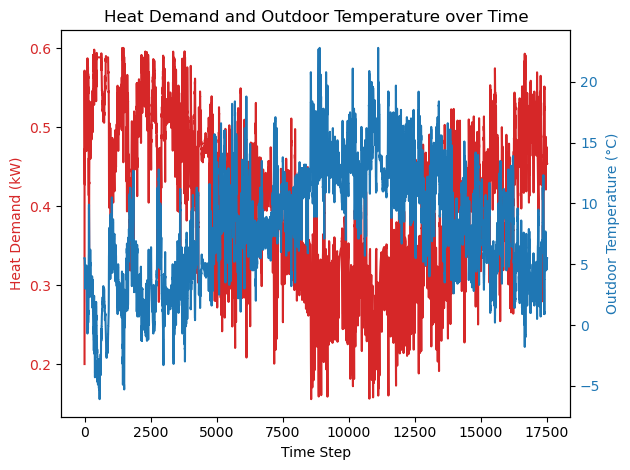

In [13]:
fig, ax1 = plt.subplots()

# Plot heat demand on primary y-axis
ax1.plot(np.arange(17520), heat_demand_profile[:17520], label='Heat Demand', color='tab:red')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Heat Demand (kW)', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(np.arange(17520), outdoor_temp_series[:17520], label='Outdoor Temp', color='tab:blue')
ax2.set_ylabel('Outdoor Temperature (°C)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title('Heat Demand and Outdoor Temperature over Time')
fig.tight_layout()  # Adjust layout to make room for the second y-axis
plt.show()

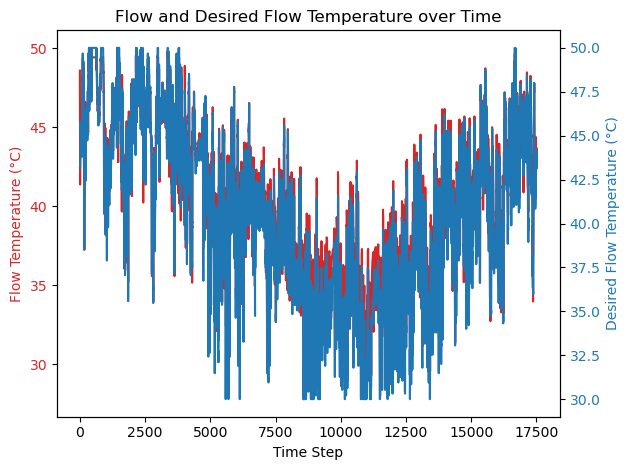

In [12]:
fig, ax1 = plt.subplots()

# Plot flow temp on primary y-axis
ax1.plot(np.arange(17520), flow_temp_series[:17520], label='Heat Demand', color='tab:red')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Flow Temperature (°C)', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(np.arange(17520), desired_flow_temp_series[:17520], label='Outdoor Temp', color='tab:blue')
ax2.set_ylabel('Desired Flow Temperature (°C)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title('Flow and Desired Flow Temperature over Time')
fig.tight_layout()  # Adjust layout to make room for the second y-axis
plt.show()